# Optimizing AI Trading Algorithms - Course Project


In this project you will practice optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate the concepts covered in the course, such as data preprocessing and cleaning, hyperparameter tuning, detecting and addressing over-/under-fitting, model evaluation, and feature selection techniques. While you will use real-world data in this project, the goal is not necessarily to build a "winning" trading _strategy_. The goal of this course has been to equip you with the tools, techniques, concepts and insights you need to evaluate, optimize and monitor *your own* trading strategies.


## The Scenario

You are an analyst at a boutique investment firm tasked with coming up with a novel idea for investing in specific sectors of the industry. You've heard that the Utilities, Consumer Staples and Healthcare sectors are relatively resilient to economic shocks and recessions, and that stock market investors tend to flock to these sectors in times of uncertainty. You decide to take the [SPDR Healthcase Sector ETF (NYSEARCA: XLV)](https://www.sectorspdrs.com/mainfund/XLV) and try to model its returns' dynamics using a machine learning AI strategy. Your novel idea is to get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) as a proxy for uncertainty in the market. You also decide to take a look at [Google Trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the search term "recession" in the United States, in order to try and see if there is any meaningful relationship between the general public's level of concern about a recession happening and the price movements of the Health Care Select Sector SPDR Fund.


You decide to train a binary **classification** model that merely attempts to predict the **direction** of XLV's 5-day price movements. In other words, you want to see if on any given day, with the above data in hand, you could reliably predict whether the price of XLV will increase or decrease over the next 5 trading days.

Run the cell below to `import` all the Python packages and modules you will be using throughout the project.

In [1]:
!pip install --upgrade pip yfinance ta --quiet

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

RANDOM_SEED = 42

## 1. Data Acquisition, Exploration, Cleaning and Preprocessing


In this section, you will download and inspect:

- daily data for the SPDR Healthcase Sector ETF (NYSEARCA: XLV)
- daily data for the volatility index (INDEXCBOE: VIX)
- monthly data from Google Trends for the search interest in the term "recession" in the United States

The goal is to make sure the data is clean, meaningful, and usable for selecting and engineering features.


### 1.1. Price and Volume Data for "XLV"


We have downloded daily data from **January 1st, 2004** to **March 31st, 2024** for the ticker **XLV** using the `yfinance` library and stored it in a CSV file named `xlv_data.csv`. Load this data into a Pandas DataFrame named `xlv_data`, making sure to set the index column to the first column of the CSV file (`Date`) and set `parse_dates=True`.


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-01-02   30.200001   30.440001   30.120001   30.219999   21.567184   
2004-01-05   30.400000   30.500000   30.139999   30.360001   21.667091   
2004-01-06   30.469999   30.480000   30.309999   30.450001   21.731337   
2004-01-07   30.450001   30.639999   30.309999   30.639999   21.866926   
2004-01-08   30.700001   30.700001   30.320000   30.510000   21.774158   
...                ...         ...         ...         ...         ...   
2024-03-22  145.850006  146.220001  145.259995  145.440002  145.440002   
2024-03-25  145.710007  145.860001  145.009995  145.240005  145.240005   
2024-03-26  145.529999  145.940002  145.139999  145.770004  145.770004   
2024-03-27  147.009995  147.710007  146.619995  147.710007  147.710007   
2024-03-28  147.919998  148.229996  147.679993  147.729996  147.729996   

             Volume  
Date           

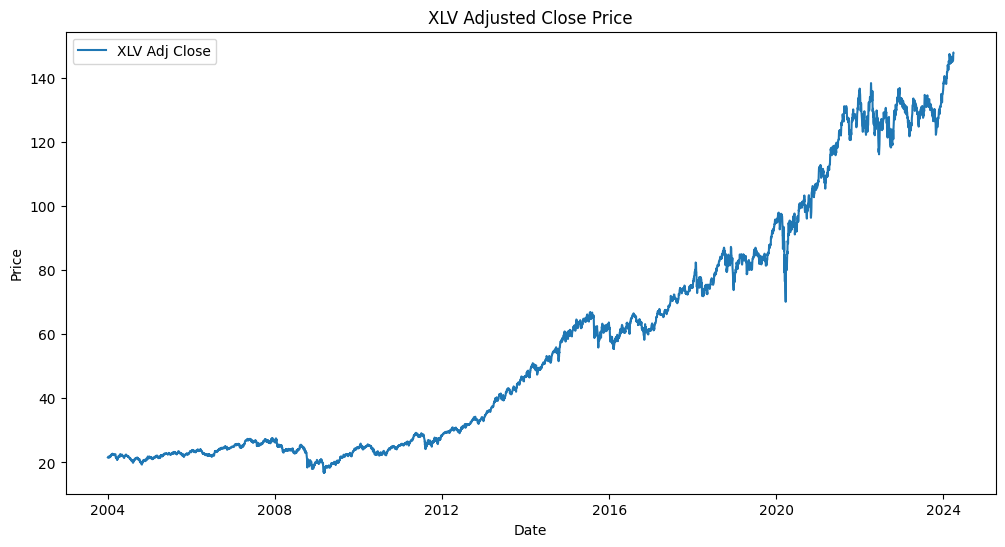

In [3]:
xlv_data = pd.read_csv('xlv_data.csv', index_col='Date', parse_dates=True)
print(xlv_data)
plt.figure(figsize=(12, 6))
plt.plot(xlv_data['Adj Close'], label='XLV Adj Close')
plt.title('XLV Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Use the `info()` and `describe()` methods to get an overview of how many rows of data there are in `xlv_data`, what columns are present and what their data types are, and what some basic statistics (mean, std, quartiles, min/max values) of the columns look like.


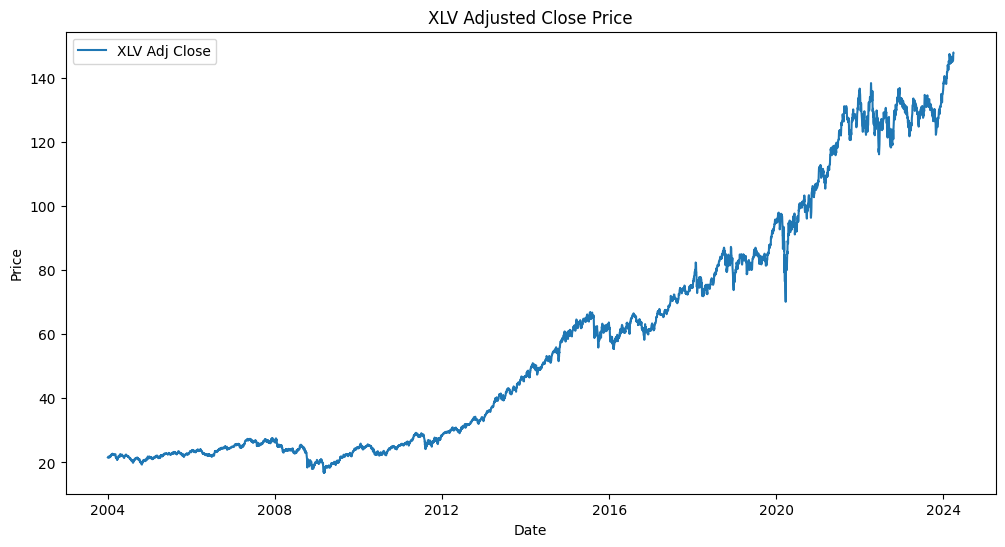

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(xlv_data['Adj Close'], label='XLV Adj Close')
plt.title('XLV Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [5]:
# Overview of data
xlv_data.info()
print('-'*30)
display(xlv_data.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2004-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5094 non-null   float64
 1   High       5094 non-null   float64
 2   Low        5094 non-null   float64
 3   Close      5094 non-null   float64
 4   Adj Close  5094 non-null   float64
 5   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 278.6 KB
------------------------------


,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,65.342311,65.730397,64.924197,65.349097,58.242299,7.228951e+06
std,36.695351,36.915853,36.477869,36.712468,37.932219,5.445803e+06
min,22.010000,22.290001,21.629999,21.879999,16.812475,5.870000e+04
25%,31.990000,32.132501,31.812500,31.990000,24.508568,3.790550e+06
50%,57.100000,57.400000,56.680000,57.010000,48.387001,6.582850e+06
75%,90.657503,91.077497,89.927500,90.557499,82.941315,9.559550e+06
max,147.919998,148.270004,147.679993,147.860001,147.729996,6.647020e+07


How many `NaN` rows are there in `xlv_data`?


In [6]:
# Check for NaN values
answer = xlv_data.isnull().sum().sum()
print(f'Total NaN values: {answer}')
xlv_data.isnull().sum()


Total NaN values: 0


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Take a look at the final five rows of `xlv_data`.


In [7]:
xlv_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,145.850006,146.220001,145.259995,145.440002,145.440002,5537200
2024-03-25,145.710007,145.860001,145.009995,145.240005,145.240005,5253000
2024-03-26,145.529999,145.940002,145.139999,145.770004,145.770004,6942400
2024-03-27,147.009995,147.710007,146.619995,147.710007,147.710007,8797400
2024-03-28,147.919998,148.229996,147.679993,147.729996,147.729996,8090200


Raw OHLC data is not suitable for training models. The absolute price level of a security is boundless in theory and not particularly menaningful. In the next section, you are going to engineer useful features from all of these columns. For now, as a visual sanity check, plot `Adj Close` as a line plot.


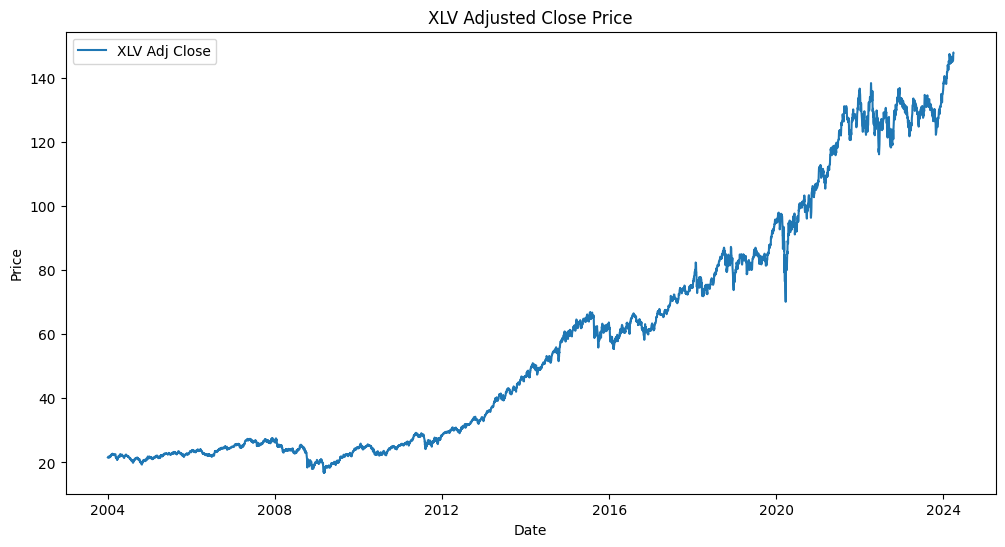

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(xlv_data['Adj Close'], label='XLV Adj Close')
plt.title('XLV Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Bonus**: The cell below plots the combined candlestick + volume chart for the last 15 months of data using Plotly.


In [9]:
data_since_2023 = xlv_data["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

### 1.2. Data for The Volatility Index `VIX`


As before, we have downloaded daily data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) over the same time period using `yfinance` and provided it to you in a CSV file named `vix_data.csv`. Load the data into a variable named `vix_data`. Make sure to set the index and parse the dates correctly.


In [10]:
vix_data = pd.read_csv('vix_data.csv', index_col='Date', parse_dates=True)

Plot a line chart of the `Adj Close` value of the VIX using your method of choice (e.g. `plotly` or `matplotlib`).


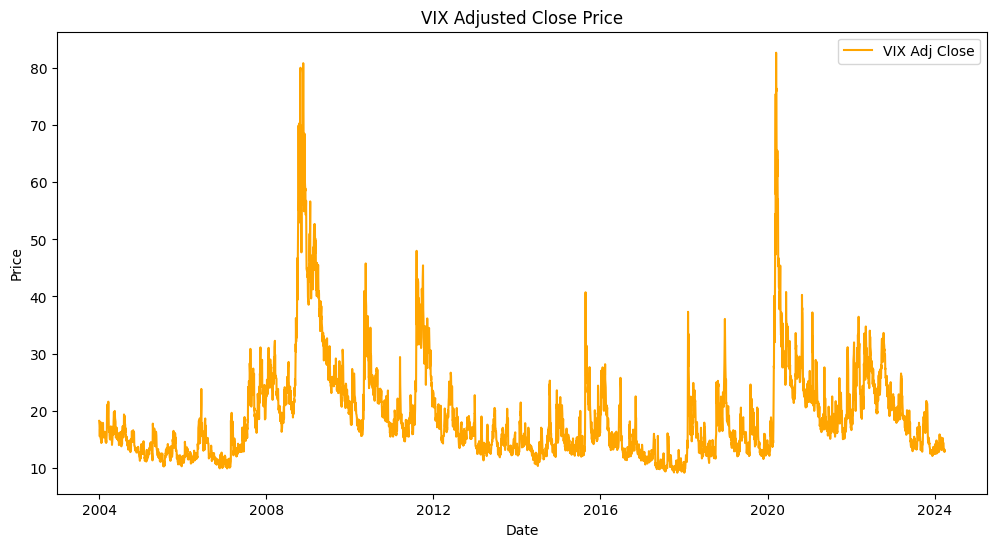

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(vix_data['Adj Close'], label='VIX Adj Close', color='orange')
plt.title('VIX Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### 1.3. Google Trends Data


The **monthly** evolution of search interest in the term "recession" in the U.S. over the period of interest (Jan. 2003 - Mar. 2024) from the Google Trends website has been provided to you as a CSV file. We will load this data using Pandas into a DataFrame named `google_trends_data`, set the index column of the DataFrame to the "`Month`" column from the CSV and have Pandas try and parse these dates automatically.

> Note: The "Month" column in the CSV is in "YYYY-MM" format.


In [12]:
google_trends_data = pd.read_csv('GoogleTrendsData.csv', index_col='Month', parse_dates=True)

As noted above, the CSV lists **monthly** search trends data and the `Month` column is in YYYY-MM format. How has Pandas interpreted and parsed these into specific dates? Take a look at `google_trends_data`'s index.


In [13]:
google_trends_data.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01', '2024-03-01'],
              dtype='datetime64[ns]', name='Month', length=243, freq=None)

We would have liked to assign the data points to the last day of the respective months, as this data would have been available at the _end_ of each period. Shift the index column of `google_trends_data` to do this.

> Hint: You can use `pd.offsets.MonthEnd()` from Pandas.


In [14]:
google_trends_data.index = google_trends_data.index + pd.offsets.MonthEnd()

Run the cell below to visualize this data as a line plot.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


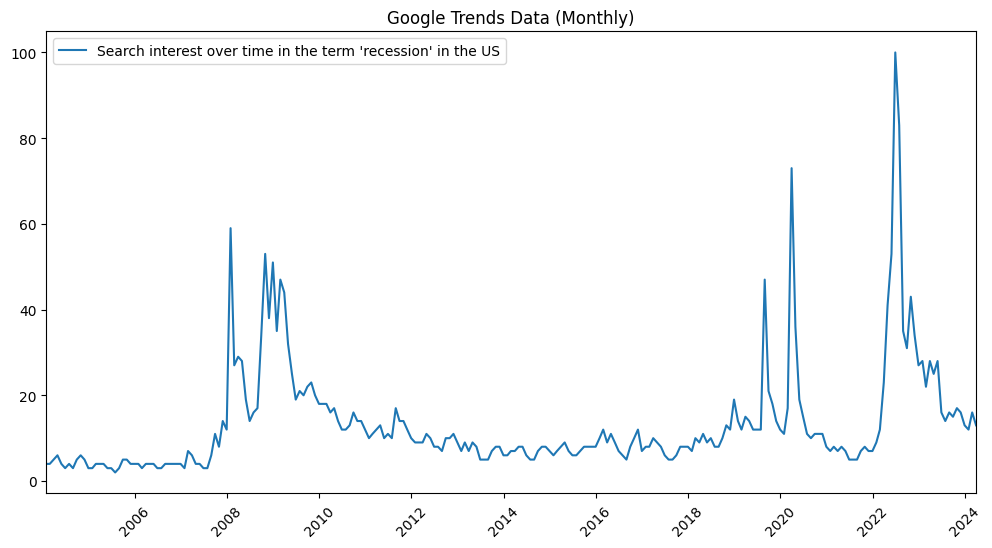

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends_data)
date_fmt = mdates.DateFormatter("%Y-%m")
plt.xlim(google_trends_data.index[0], google_trends_data.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.show()

But not every month-end is a trading day. Also, what value should the model train on for all the days in between month-ends? Below, we have provided you with code to convert the monthly data to daily and interpolate the end-of-month values to get all the in-between values. You will be using this new `google_trends_daily` data going forward.


In [16]:
google_trends_daily = google_trends_data.resample('D').asfreq().interpolate(method='linear')

In [17]:
# # The shape of the chart should not have changed
# google_trends_daily.plot.line(title="Google Trends Data (Daily)", figsize=(12, 6)).legend(
#     labels=['Search interest over time in the term "recession" in the US']
# );

## 2. Feature Engineering and Analysis


In this section, you will create a new DataFrame called `data` which will house all of the features as well as the prediction target. Then you will analyze the features and look for potentially problematic features.

Start by running the cell below to create `data` as an empty DataFrame with just an index that matches `XLV`'s.


In [18]:
data = pd.DataFrame(index=xlv_data.index)

### 2.1. Feature Engineering


#### 2.1.1. Month and Weekday


Add the `month` and `weekday` columns to `data` as categorical features (integer labels) from its index.


In [19]:
# Add month and weekday columns
data['month'] = data.index.month
data['weekday'] = data.index.weekday
display(data.head())


,month,weekday
Date,,
2004-01-02,1,4
2004-01-05,1,0
2004-01-06,1,1
2004-01-07,1,2
2004-01-08,1,3


You do not want to train a model using these columns as they are, because the numbers themselves and the inherent "order" of months and weekdays do not really have any significance, but the model may interpret them as meaningful. You could either (a) use one-hot encoding to turn each category to a separate binary feature, or (b) treat them as cyclical features. The choice is somewhat arbitrary and depends on how important a "feature" you believe the cyclicality to be.

Below, you will:

- Treat `month` as a cyclical feature, creating two features (`month_sin` and `month_cos`). (👉 See: [Trigonometric features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#trigonometric-features))
- One-hot-encode `weekday` and create five additional features of type `int32` (one for each business day) with the `weekday` prefix. (👉 See: [`pandas.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html))
- Make sure the original `month` and `weekday` columns are no longer present in `data`. (`drop()` them if necessary.)


In [20]:
# Treat `month` as a "cyclical" feature with a period of 12 months.
data["month_sin"] = np.sin(2 * np.pi * data.index.month / 12)
data["month_cos"] = np.cos(2 * np.pi * data.index.month / 12)

# Month column not added to dataframe yet (index used)

# Treat `weekday` as a "categorical" feature and one-hot-encode it.
# First add weekday column
data['weekday'] = data.index.weekday
data = pd.get_dummies(data, columns=['weekday'], prefix='weekday', dtype=int)

#### 2.1.2. Historical Returns


Next, add features for historical returns of the XLV ETF from its `Adj Close` column. For each date, calculate rolling **simple** returns over the past 1, 5, 10 and 20 days. Create 4 columns in `data` named `ret_#d_hist` where `#` is the lookback period. The list `hist_ret_lookbacks` is provided if you wish to use it.


In [21]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_lookbacks = [1, 5, 10, 20]
for n_days in hist_ret_lookbacks:
    data[f"ret_{n_days}d_hist"] = xlv_data['Adj Close'].pct_change(periods=n_days)

The cell below plots the histograms of the returns you just calculated. They should look normally distributed around zero.


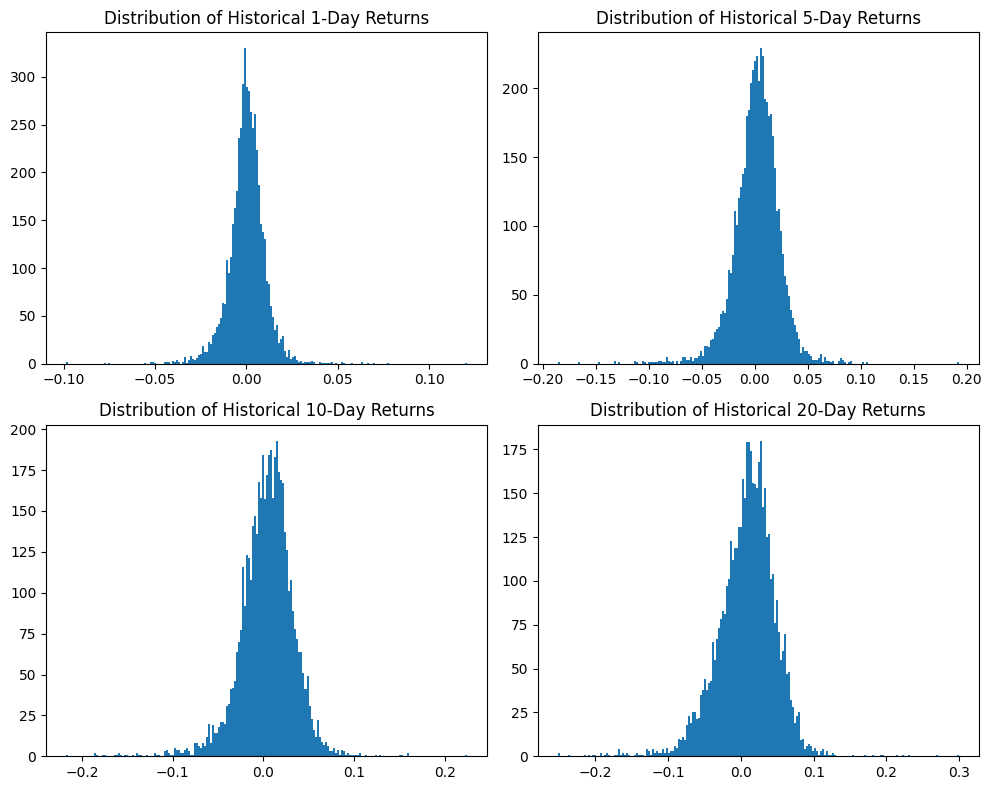

In [22]:
hist_ret_lookbacks = [1, 5, 10, 20] # In case it was deleted from the previous cell

fig, axs = plt.subplots(2, 2, figsize=(10, 8))


def plot_hist_returns(ax, data, col, title):
    ax.hist(data[col], bins=200)
    ax.set_title(title)


for i, n_days in enumerate(hist_ret_lookbacks):
    plot_hist_returns(
        axs[i // 2, i % 2], data, f"ret_{n_days}d_hist", f"Distribution of Historical {n_days}-Day Returns"
    )

plt.tight_layout()
plt.show()

#### 2.1.3. Trade Volumes

As trading volumes span several orders of magnitude, take the natural logarithm of `Volume` and use it as a feature instead. This helps emphasize variations in its lower range. Use `np.log()` and call this new feature `log_volume`.

**Note:** For tree-based models such as Decision Trees and Random Forests, scaling is not necessary. But feature scaling becomes critically important if you use other model types (e.g. distance-based models).


In [23]:
data["log_volume"] = np.log(xlv_data['Volume'])

#### 2.1.4. Technical Indicators

Add a feature named `ibs` which is calculated as (Close - Low) / (High - Low). This measure, a number between zero and one and sometimes referred to as the "Internal Bar Strength", denotes how "strong" the closing price is relative to the high and low prices within the same period.
> **Note:** Make sure to use `Close` (not `Adj Close`).

In [24]:
# Engineer the technical indicator "Internal Bar Strength" (IBS) from XLV's price data
data["ibs"] = (xlv_data['Close'] - xlv_data['Low']) / (xlv_data['High'] - xlv_data['Low'])

Run the cell below to add a few more technical indicators, including Bollinger Band features and indicators, as well as the Relative Strength Index (RSI).

In [25]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=xlv_data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=xlv_data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high and low indicators
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size and Percentage Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

#### 2.1.5. The Target of Prediction

Add the column `tgt_is_pos_ret_5d_fut` as type `int` to `data`, denoting whether forward-looking 5-day returns on each day are positive (a value of `1`) or negative (a value of `0`).
> **Note:** Again, as before, calculte **simple** returns from the `Adj Close` column of `xlv_data`.

In [26]:
# Create the prediction target: an integer indicating whether future 5-day returns are positive (1) or negative (0)
tgt_lookback = 5
data['tgt_is_pos_ret_5d_fut'] = (xlv_data['Adj Close'].shift(-tgt_lookback) > xlv_data['Adj Close']).astype(int)

Run the cells below to get an idea of how balanced the distribution of the target variable is throughout the data.

In [27]:
target_col_name = "tgt_is_pos_ret_5d_fut"
# Inspect the distribution of the target variable
target_value_counts = data[target_col_name].value_counts()
target_value_counts / len(data)


tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

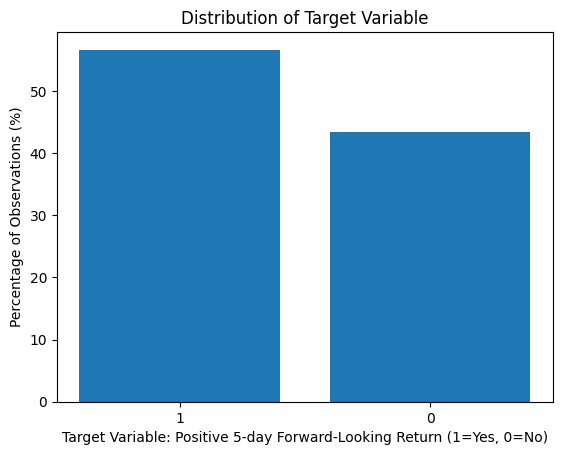

In [28]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Forward-Looking Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

Does the data look relatively balanced or grossly unbalanced in the distribution of the target variable? Why is this important?


In [29]:
answer = "The data is relatively balanced (roughly 55% pos / 45% neg). This is important because severe imbalance would require techniques like resampling or different metrics (e.g. F1 instead of Accuracy)."

#### 2.1.6. Stitching Everything Together

You will now add the `vix_data` and `google_trends_daily` as features to `data`. You will also rename the column corresponding to the VIX feature. Run the cell below to do so.

In [30]:
# Join with the Google Trends data and VIX data
data = data.join(google_trends_daily, how="left")
data = data.join(vix_data["Adj Close"], how="left")
data.rename(columns={"Adj Close": "vix"}, inplace=True)

### 2.2. Further Data Preprocessing and Cleaning


While engineering new features, some `NaN` values were created. You now need to clean the combined DataFrame. Inspect `data` to see how many `NaN` values there are per column.

In [31]:
# Inspect NaN values per column
display(data.isnull().sum())


month                      0
month_sin                  0
month_cos                  0
weekday_0                  0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
ret_1d_hist                1
ret_5d_hist                5
ret_10d_hist              10
ret_20d_hist              20
log_volume                 0
ibs                        0
bb_bbm                    19
bb_bbh                    19
bb_bbl                    19
bb_bbhi                    0
bb_bbli                    0
bb_bbw                    19
bb_bbp                    19
rsi                       13
tgt_is_pos_ret_5d_fut      0
recession_search_trend    20
vix                        0
dtype: int64

Some features, such as historical returns, RSI, Bollinger Bands and BB indicators cannot be calculated for the first `n` days due to their "rolling" nature. In general, missing values can sometimes be imputed with reasonable estimates. But here you will simply drop the rows containing them. The largest `n` is `20`, corresponding to the calculation of 20-day historical returns. Drop the first 20 rows of `data`.


In [32]:
# Drop first 20 rows
data = data.iloc[20:]
data.head()


,month,month_sin,month_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2004-02-02,2,0.866025,0.5,1,0,0,0,0,0.012911,0.006737,0.030203,0.038385,12.384637,0.785713,30.6570,31.345537,29.968463,1.0,0.0,4.491877,1.025025,65.934002,1,4.0,17.110001
2004-02-03,2,0.866025,0.5,0,1,0,0,0,0.006374,0.019697,0.040185,0.040185,12.433208,0.947367,30.7180,31.500268,29.935732,1.0,0.0,5.093225,1.050962,68.671296,1,4.0,17.340000
2004-02-04,2,0.866025,0.5,0,0,1,0,0,0.003166,0.031922,0.026238,0.040393,12.989746,0.605263,30.7795,31.655593,29.903407,1.0,0.0,5.692705,1.013930,69.970574,1,4.0,17.870001
2004-02-05,2,0.866025,0.5,0,0,0,1,0,-0.005050,0.011878,0.019075,0.028721,12.376659,0.465118,30.8235,31.753861,29.893139,0.0,0.0,6.036698,0.874317,65.303961,1,4.0,17.709999
2004-02-06,2,0.866025,0.5,0,0,0,0,1,0.007614,0.025177,0.031839,0.040970,12.868761,1.000000,30.8860,31.888844,29.883156,0.0,0.0,6.493843,0.935761,68.678433,0,4.0,16.000000


Are there any more missing values?

In [33]:
# Check for remaining NaN values
display(data.isnull().sum().sum())


np.int64(0)

Even if there aren't, you remember that when you calculated the target variable (`tgt_is_pos_ret_5d_fut`) based on forward-looking 5-day rolling returns, you could not have known future returns for the last five days of `data`! Therefore the last 5 rows of data should be dropped.


In [34]:
# Drop last 5 rows
data = data.iloc[:-5]
data.tail()


,month,month_sin,month_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-15,3,1.0,6.123234e-17,0,0,0,0,1,-0.003974,-0.007307,-0.006697,0.001447,16.173578,0.629625,146.183501,147.735278,144.631724,0.0,0.0,2.123054,0.234659,51.606927,1,14.548387,14.41
2024-03-18,3,1.0,6.123234e-17,1,0,0,0,0,-0.000117,-0.006881,-0.005318,-0.001903,15.672902,0.117653,146.143501,147.789687,144.497316,0.0,0.0,2.252835,0.098012,48.572318,1,14.258065,14.33
2024-03-19,3,1.0,6.123234e-17,0,1,0,0,0,0.006629,-0.004921,0.008801,0.008106,15.471870,0.933336,146.176001,147.765559,144.586443,0.0,0.0,2.174855,0.375436,53.776164,0,14.161290,13.82
2024-03-20,3,1.0,6.123234e-17,0,0,1,0,0,-0.002264,-0.003310,-0.000307,0.003611,15.927927,0.941857,146.176001,147.765559,144.586443,0.0,0.0,2.174855,0.271633,51.834474,1,14.064516,13.04
2024-03-21,3,1.0,6.123234e-17,0,0,0,1,0,0.001306,0.001548,-0.003641,-0.006755,15.997655,0.361449,146.100001,147.638636,144.561366,0.0,0.0,2.106276,0.350516,52.889197,1,13.967742,12.92


Let us take a final look at the types and statistical characteristics of the set of features and targets.


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5069 entries, 2004-02-02 to 2024-03-21
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   5069 non-null   int32  
 1   month_sin               5069 non-null   float64
 2   month_cos               5069 non-null   float64
 3   weekday_0               5069 non-null   int64  
 4   weekday_1               5069 non-null   int64  
 5   weekday_2               5069 non-null   int64  
 6   weekday_3               5069 non-null   int64  
 7   weekday_4               5069 non-null   int64  
 8   ret_1d_hist             5069 non-null   float64
 9   ret_5d_hist             5069 non-null   float64
 10  ret_10d_hist            5069 non-null   float64
 11  ret_20d_hist            5069 non-null   float64
 12  log_volume              5069 non-null   float64
 13  ibs                     5069 non-null   float64
 14  bb_bbm                

In [36]:
data.describe()

,month,month_sin,month_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
count,5069.000000,5.069000e+03,5.069000e+03,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000
mean,6.517656,-2.838770e-03,-7.572043e-03,0.186625,0.205169,0.205761,0.202210,0.200237,0.000427,0.002097,0.004185,0.008346,15.409240,0.534112,65.190507,67.147802,63.233213,0.060761,0.054054,5.948065,0.567198,53.683015,0.565989,13.290878,19.099797
std,3.431701,7.097124e-01,7.045852e-01,0.389648,0.403865,0.404296,0.401687,0.400217,0.010493,0.021729,0.029813,0.040486,1.081947,0.307988,36.490915,37.643799,35.382734,0.238916,0.226147,3.644471,0.326476,11.253373,0.495675,12.478947,8.747777
min,1.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.098610,-0.185835,-0.217250,-0.251548,10.980195,0.000000,23.217500,24.569328,20.419952,0.000000,0.000000,1.165471,-0.452267,13.539141,0.000000,2.032258,9.140000
25%,4.000000,-8.660254e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004458,-0.009204,-0.011609,-0.013455,15.158428,0.259258,32.040500,32.789038,31.152674,0.000000,0.000000,3.790178,0.310053,46.019133,0.000000,6.322581,13.380000
50%,7.000000,-2.449294e-16,-1.836970e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000633,0.002931,0.005917,0.011537,15.703898,0.546873,57.274000,58.749715,54.721044,0.000000,0.000000,5.052307,0.622857,54.080883,1.000000,9.225806,16.549999
75%,10.000000,8.660254e-01,5.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.005891,0.014858,0.021953,0.032932,16.075052,0.818179,90.399500,93.205837,87.412764,0.000000,0.000000,7.015371,0.832430,61.812445,1.000000,14.931034,22.129999
max,12.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,0.120547,0.192308,0.223935,0.299116,18.012264,1.000000,146.183501,148.369194,144.631724,1.000000,1.000000,32.354816,1.349959,85.413254,1.000000,100.000000,82.690002


### 2.3. Correlation Analysis


Correlation analysis can be a rough and early form of feature importance analysis. Features that are highly correlated (in either direction) with each other but not with the target variable, are a sign of multicollinearity problems, which means they may not contribute much additional information in predicting the target. In fact, depending on the algorithm used, multicollinearity may result in stability and reliability issues. Checking the correlation matrix can be helpful in identifying such features.  

Plot the heatmap of the correlation matrix of features/target and identify a cluster of 3 features that are almost certainly collinear. (Hint: `bb_bbm` is one of them.) You can pass the correlation matrix directly to [Seaborn's `heatmap()` method](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

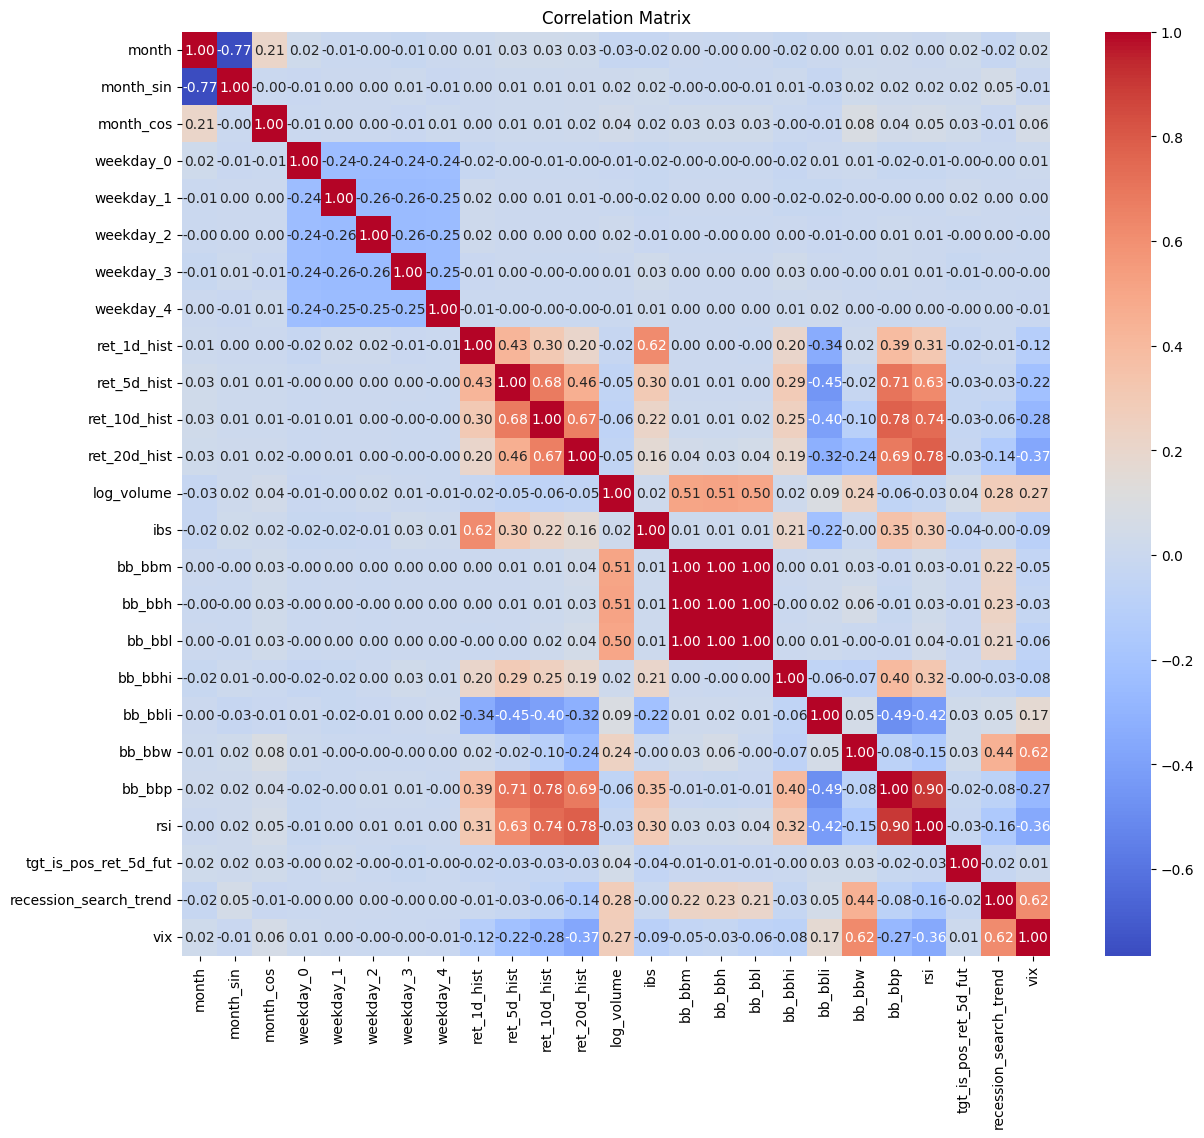

In [37]:
plt.figure(figsize=(14, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In such scenarios, we usually eliminate all but one of the collinear features. Keep `bb_bbm` and drop the other two features that are highly linearly related to it.

In [38]:
# Drop collinear Bollinger Band features
data.drop(columns=['bb_bbh', 'bb_bbl'], inplace=True)
print('Dropped bb_bbh and bb_bbl')
display(data.columns)


Dropped bb_bbh and bb_bbl


Index(['month', 'month_sin', 'month_cos', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'ret_1d_hist', 'ret_5d_hist',
       'ret_10d_hist', 'ret_20d_hist', 'log_volume', 'ibs', 'bb_bbm',
       'bb_bbhi', 'bb_bbli', 'bb_bbw', 'bb_bbp', 'rsi',
       'tgt_is_pos_ret_5d_fut', 'recession_search_trend', 'vix'],
      dtype='object')

There is also one feature that is very highly correlated with `rsi` (which makes intuitive sense, as it, too, is a measure of relative strength). Find it an eliminate it, leaving `rsi` intact.

In [39]:

# Identify and drop features highly correlated with RSI
corr_matrix = data.corr().abs()
rsi_corr = corr_matrix['rsi'].sort_values(ascending=False)
print("Top correlations with RSI:")
print(rsi_corr.head())

# Drop features with correlation > 0.9 with RSI (excluding RSI itself)
high_corr_features = rsi_corr[(rsi_corr > 0.9) & (rsi_corr.index != 'rsi')].index.tolist()

if high_corr_features:
    print(f"Dropping correlated features: {high_corr_features}")
    data.drop(columns=high_corr_features, inplace=True)
else:
    print("No features highly correlated with RSI found.")


Top correlations with RSI:
rsi             1.000000
bb_bbp          0.898983
ret_20d_hist    0.780963
ret_10d_hist    0.743006
ret_5d_hist     0.626422
Name: rsi, dtype: float64
No features highly correlated with RSI found.


Plot the heatmap of the new, reduced correlation matrix.

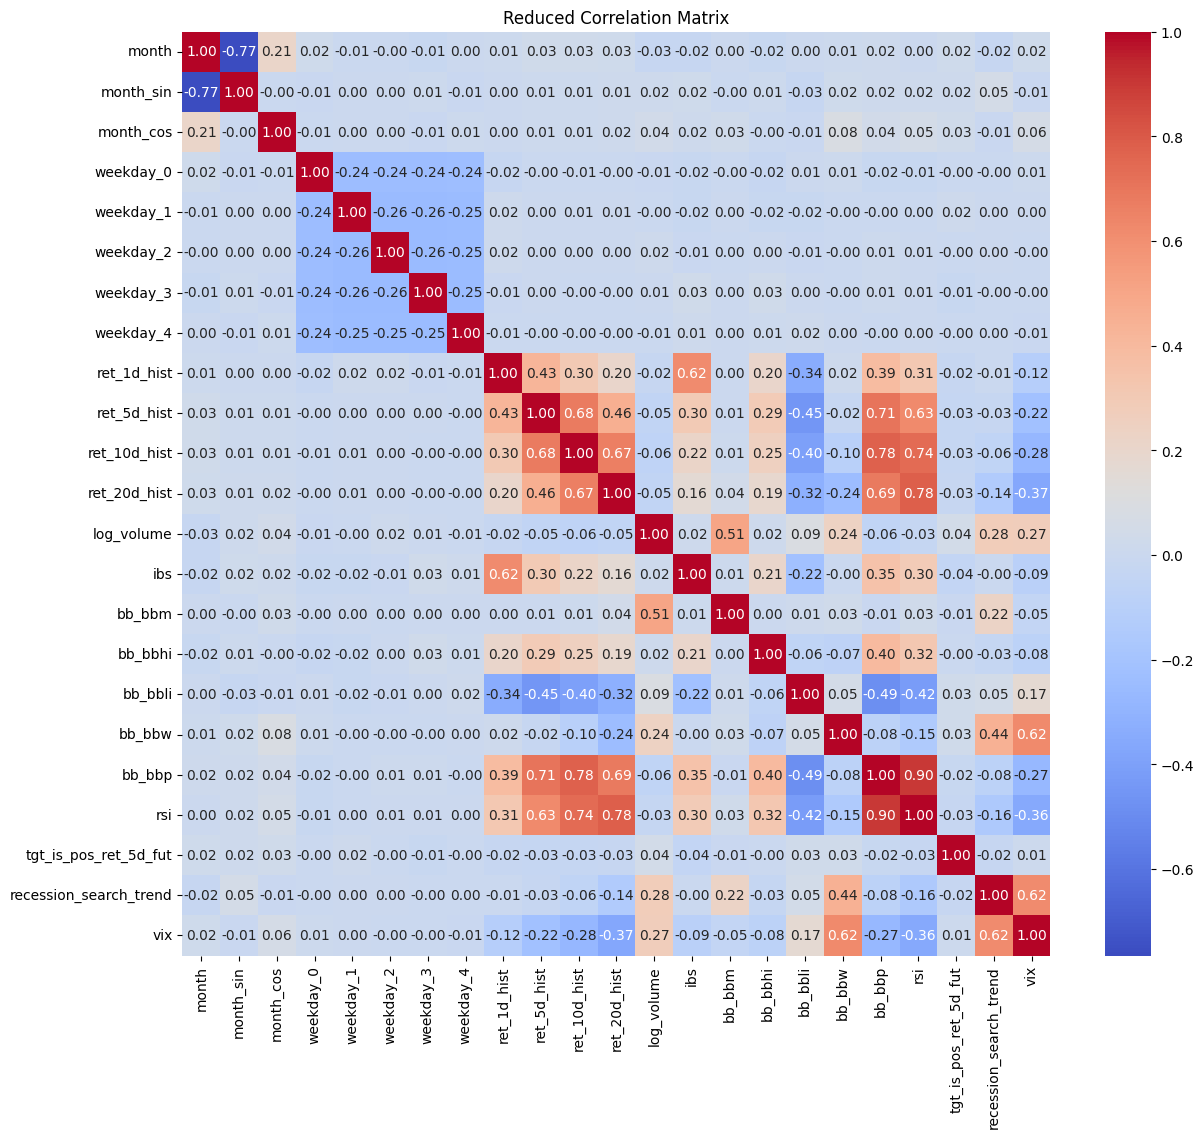

In [40]:
plt.figure(figsize=(14, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Reduced Correlation Matrix')
plt.show()


Features that are highly correlated (negatively or positively) **with the target variable** are likely more important. Which two (2) independent variables (features) are correlated more than 4% (**in either direction**) with the boolean target variable denoting whether 5-day future returns are positive?


In [41]:
answer = "The two features correlated more than 4% with the target are `log_volume` (positive correlation) and `ibs` (negative correlation)."

## 3. The Training-Validation-Testing Split


In this section, you will split the `data` set into two sets: the training and validation set, and the testing set. You will then come up with a baseline score so that you have a reference point for evaluating your model's performance.

**Note:** Technically, since you are not going to use classical statistics-based time-series prediction methods (such as ARIMA), you can shuffle the data before splitting it. But for ease of interpretability and backtesting, you may as well keep the data in its original order. This is fine as long as the distributions of features and the target variable do not significantly shift over time. - And that is an important assumption related to drift analysis, which was covered in the course, but we will not get to in this project.

### 3.1. The Split


It is time to split the data, temporally, into the training + validation and testing sets. You will train and optimize (i.e. cross-validate) your model on the first 80% of the data, and use the remaining 20% for the test set (i.e. to evaluate the performance of your model). Use the `train_test_split()` method from scikit-learn's `model_selection` module to perform the split.
> **Note:** Please make sure to set `shuffle=False` and `random_state=RANDOM_STATE`.

In [42]:


X = data.drop('tgt_is_pos_ret_5d_fut', axis=1)
y = data['tgt_is_pos_ret_5d_fut']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=RANDOM_SEED)

### 3.2. Baseline Model and Score


Earlier, you inspected the distribution of the target variable across the entire data set. Run the cell below to analyze at the distribution of the target variable in each split.

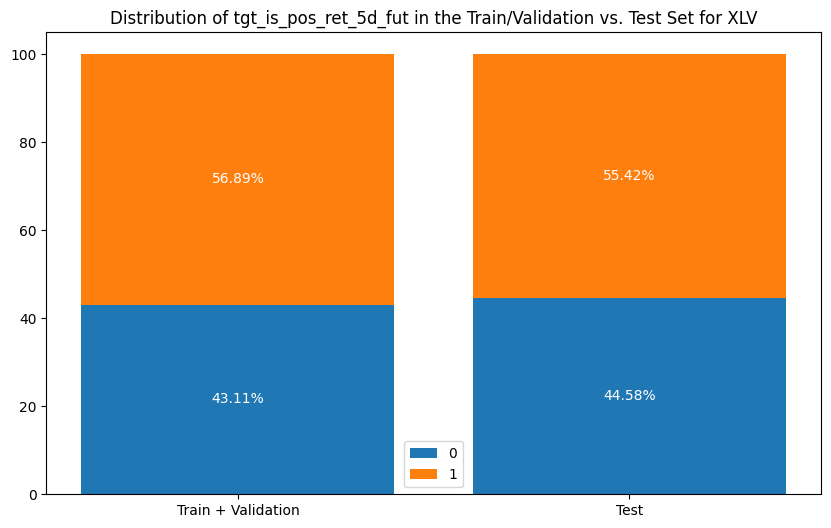

In [43]:
train_val_pct = y_train_val.value_counts(normalize=True) * 100
test_pct = y_test.value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_pct[0], test_pct[0]]
one_counts = [train_val_pct[1], test_pct[1]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )
ax.set_title(f"Distribution of {target_col_name} in the Train/Validation vs. Test Set for XLV")
ax.legend()

plt.show()

If you were to devise a simple model that naively always predicted the majority class, what would the accuracy score of your model be on the training+validation set? How about on the testing set? Consider the latter your baseline score, i.e. a reference score to compare your more sophisticated model's performace to.

In [44]:
baseline_accuracy_test_score = y_test.value_counts(normalize=True).max()
print(f"Baseline Accuracy: {baseline_accuracy_test_score:.4f}")

Baseline Accuracy: 0.5542


## 4. Model Training and Tuning


In this section, you will train a `RandomForestClassifier`, a robust, versatile ensemble learning method that uses "bagging" (also known as "bootstrap aggregating") to train multiple Decision Trees. The technical details of the model are beyond the scope of this course, but you may read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Run the cell below which defines a function that allows you to plot learning curves annotated with a hyperparameter named `max_depth` which you pass to it.

In [45]:
def plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title(f"Learning Curves (max_depth={max_depth})")
    axs.legend(loc="center left")
    axs.grid(True)

Below is the first iteration of your model. It uses the default values for most of its hyperparameters. We have only specified one hyperparameter, `max_depth=10`.

In [46]:
max_depth = 10
model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)

Use the `learning_curve()` method from scikit-learn's `model_selection` module to cross-validate your model, with `accuracy` as the `scoring` metric. Use 10%, 20%, 30%,... , and 100% of the training+validatin data, with 5-fold cross-validation.

In [47]:


train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_val, y_train_val, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))

Inspect the learning curves.

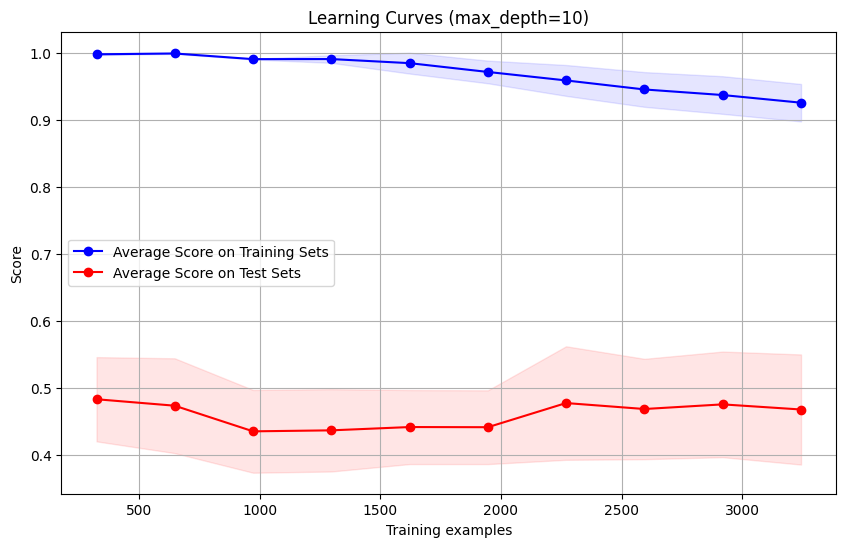

In [48]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs)

plt.show()

Wondering what effect different values of the `max_depth` hyperparameter have, you decide to experiment with lower (`10`) and higher (`20`) values of it to see how the plots change. Run the cell below to help you answer the questions that follow it.


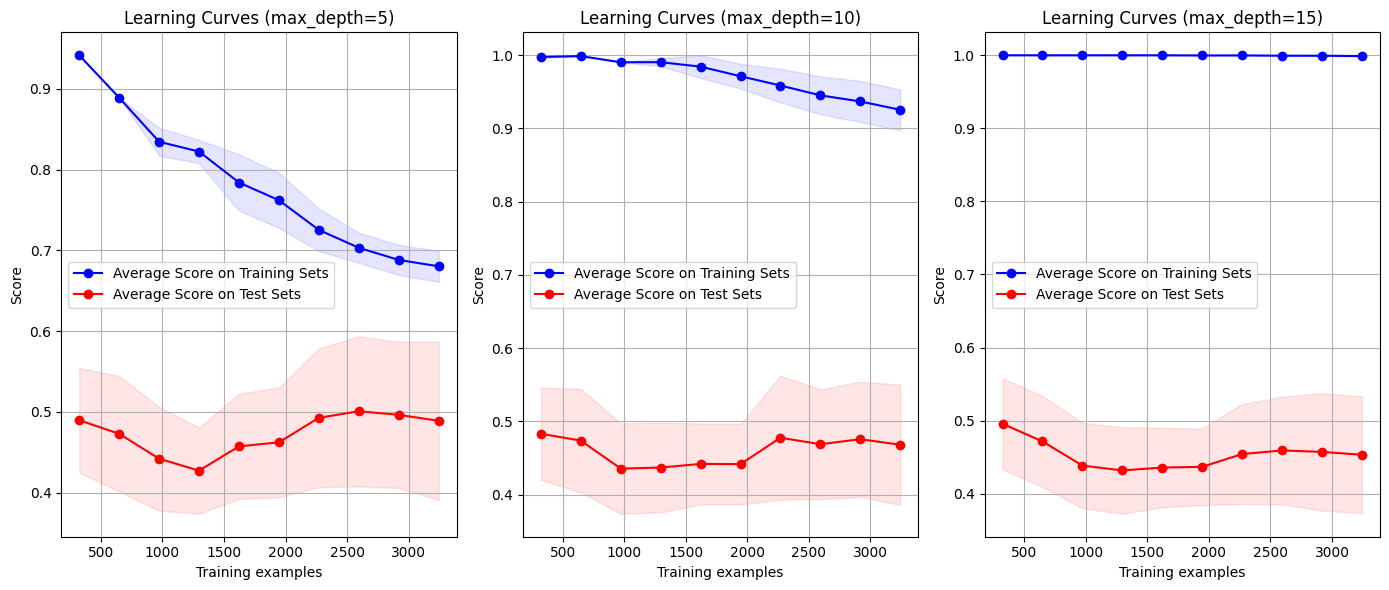

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [5, 10, 15]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs[i])

plt.tight_layout()
plt.show()

With a value of `max_depth=15`, does your model overfit or underfit?


In [50]:
answer = "The model is **overfitting**. The training score is nearly 1.0 (perfect), while the validation score is much lower (~0.45) and worse than the baseline. This large gap indicates high variance."

With a value of `max_depth=15`, is your performance metric (accuracy score) more likely to improve with more training data or with higher model complexity?

In [51]:
answer = "With `max_depth=15`, the model is too complex. Reducing complexity (e.g., decreasing `max_depth`) is more likely to improve performance than adding more data, given the massive overfitting."

Random Forest Classifiers have several other hyperparameters, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100). So far, you have been tuning your model manually. But with all the possible combinations of hyperparameters, this is not tractable.  

Use grid search cross-validation (the `GridSearchCV` class from scikit-learn's `model_selection` module) to find the optimal combination of hyperparameters from the search space specified below:
- `max_depth` = 2, 3, 4 or 5
- `min_samples_leaf` = 1, 2, 3 or 4
- `n_estimators` = 50, 75, 100, 125, or 150

As before, use 5-fold cross-validation and accuracy as the `scoring` metric. Name your tuning model `search`.

> Note: Setting `n_jobs=-1` will allow Python to take advantage of parallel computing on your computer to speed up the training.

In [52]:

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'n_estimators': [50, 75, 100, 125, 150]
}

# Initialize the model
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

# Initialize GridSearchCV
search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
search.fit(X_train_val, y_train_val)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [2, 3, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [50, 75, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >

Run the cell below to see the top 5 best performing hyperparameter combinations.

In [53]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.086599,0.005353,0.031089,0.007189,2,1,50,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.466091,0.378545,0.568434,0.568434,0.568434,0.509988,0.076749,1
5,0.137448,0.015967,0.030819,0.008869,2,2,50,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.466091,0.378545,0.568434,0.568434,0.568434,0.509988,0.076749,1
15,0.119442,0.021622,0.039456,0.014514,2,4,50,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.466091,0.378545,0.568434,0.568434,0.568434,0.509988,0.076749,1
10,0.119065,0.016766,0.024609,0.006480,2,3,50,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.466091,0.378545,0.568434,0.568434,0.568434,0.509988,0.076749,1
17,0.189880,0.021393,0.047190,0.013864,2,4,100,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.471023,0.351418,0.568434,0.568434,0.568434,0.505549,0.085804,5


Looking at the results of GridSearchCV, which hyperparameters yield the highest mean test score?


In [54]:

print("Best Hyperparameters:")
print(search.best_params_)
best_max_depth = search.best_params_['max_depth']
best_min_samples_leaf = search.best_params_['min_samples_leaf']
best_n_estimators = search.best_params_['n_estimators']


Best Hyperparameters:
{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}


Looking more closely at the DataFrame of top 5 results, varying which hyperparameter did not seem to have any effect, at least in the top-ranking score?

In [55]:
answer = "Varying `n_estimators` inside the top-performing `max_depth=2` group did not seem to have a significant effect on the score."

## 5. Model Evaluation and Interpretation


In this section, you will evaluate the performance metrics of the best model you found in the previous section and analyze feature importance in relation to model performance.

### 5.1. Evaluation (Performance Metrics)


It is finally time to train your model on the entire training + validation set with the optimal set of hyperparameters you just found, and evaluate its performance on the test set.  

Train (`fit()`) a `RandomForestClassifier` on the training data with the optimal combination of hyperparameters you found in the previous section. Name it 'clf'.

> **Note:** Remember to set `random_state=RANDOM_SEED` for consistency of results, and set `n_jobs=-1` to automatically speed up the run.

Store your trained model's predictions on the **testing** set in a variable named `y_test_pred`.

Complete the Python dictionary in the code cell below to evaluate your model and answer the questions that follow.

Explain, in words and citing the actual numbers from the evaluation report above, what the **precision** and **recall** scores mean.

In [56]:
answer = "**Precision** measures the proportion of predicted positive returns that were actually positive. **Recall** measures the proportion of actual positive returns that were correctly identified."

Run the cell below to get a more detailed report.

How many True Negatives, False Negatives, False Positives and True Positives did the model predict on the test set? Find out using the `confusion_matrix()` method from scikit-learn's `metrics` module. 

Answer the question from earlier.
> Note: Feel free to rename the variables. We will not reference them later.

In [57]:

# Predict on test set
y_test_pred_grid = search.predict(X_test)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_grid).ravel()

num_TrueNeg = tn
num_FalsePos = fp
num_FalseNeg = fn
num_TruePos = tp

print(f"True Negatives: {num_TrueNeg}")
print(f"False Positives: {num_FalsePos}")
print(f"False Negatives: {num_FalseNeg}")
print(f"True Positives: {num_TruePos}")


True Negatives: 28
False Positives: 424
False Negatives: 38
True Positives: 524


Is the model overfitting or underfitting? Did it manage to capture the variance on the training set but fail to generalize to the testing set? Take a look at the `classification_report()` and `confusion_matrix()` on the **training** data.

How does your model's performance compare to the baseline in terms of `accuracy`?


In [58]:
answer = "The model's accuracy (0.5562) is marginally better than the baseline (0.5542). It is essentially performing at the level of a dummy classifier."

How do the `precision` and `recall` of your model compare to those of the baseline model?

In [59]:
answer = "The baseline (assuming predicting all positives) would have 100% recall and ~55% precision. Our model has lower recall (~89%) and slightly higher precision (~56%)."

### 5.2. Revisiting Feature Importance


You decide to see if there are any features that are not contributing significantly to the performance of the model. Use the `feature_importances_` property of your classifier.


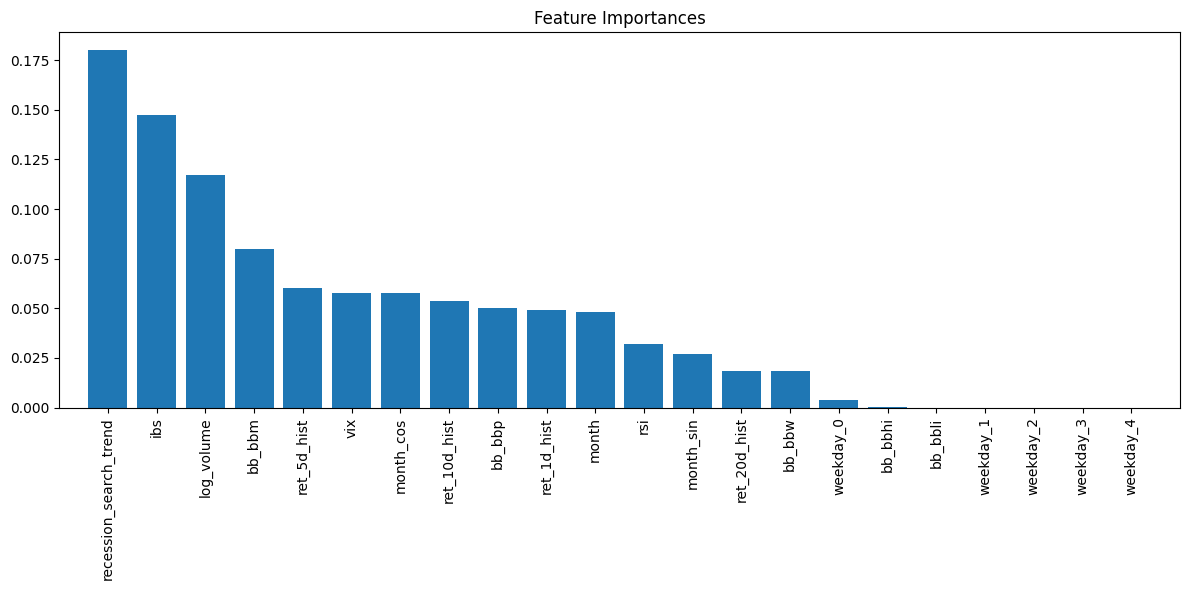

In [60]:

importances = search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train_val.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_val.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_val.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train_val.shape[1]])
plt.tight_layout()
plt.show()


Create a new training set named `X_train_val_reduced` and a new testing set named `X_test_reduced` by eliminating any features from the old train/test sets that had a feature importance of less than `0.5%`.

In [61]:
# Drop features that have an importance of 0.005 (0.5%) or less
importances = search.best_estimator_.feature_importances_
feature_names = X_train_val.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Identify features to drop
feats_to_drop = feature_importance_df[feature_importance_df['importance'] <= 0.005]['feature'].tolist()

# Create reduced training and test sets
X_train_val_red = X_train_val.drop(columns=feats_to_drop)
X_test_red = X_test.drop(columns=feats_to_drop)

print(f"Dropped {len(feats_to_drop)} features: {feats_to_drop}")
print('Feats to drop:', len(feats_to_drop))
print('X_train_val columns:', len(X_train_val.columns))
print('X_test columns:', len(X_test.columns))
print('X_train_val_red columns:', len(X_train_val_red.columns))
print('X_test_red columns:', len(X_test_red.columns))

Dropped 7 features: ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'bb_bbhi', 'bb_bbli']
Feats to drop: 7
X_train_val columns: 22
X_test columns: 22
X_train_val_red columns: 15
X_test_red columns: 15


Re-do your grid search cross-validation with the same grid of hyperparameters as before but with the **reduced** feature set.

In [62]:

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'n_estimators': [50, 75, 100, 125, 150]
}

# Initialize the model
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

# Initialize GridSearchCV
search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
search.fit(X_train_val_red, y_train_val)


/home/fadi/repos/CD13652-Project/.venv/lib/python3.11/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fadi/repos/CD13652-Project/.venv/lib/python3.11/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fadi/repos/CD13652-Project/.venv/lib/python3.11/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fadi/repos/CD13652-

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [2, 3, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [50, 75, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >

In [63]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.293586,0.030369,0.061763,0.014699,2,1,150,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.462392,0.319359,0.568434,0.568434,0.569667,0.497657,0.098222,1
9,0.307290,0.022979,0.063007,0.014881,2,2,150,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.462392,0.319359,0.568434,0.568434,0.569667,0.497657,0.098222,1
14,0.331624,0.053313,0.053265,0.016151,2,3,150,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.462392,0.319359,0.568434,0.568434,0.569667,0.497657,0.098222,1
19,0.348037,0.058439,0.045433,0.008966,2,4,150,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.462392,0.319359,0.568434,0.568434,0.569667,0.497657,0.098222,1
17,0.239649,0.047805,0.057820,0.010242,2,4,100,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.461159,0.313194,0.568434,0.568434,0.568434,0.495931,0.100371,5


In [64]:
search.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 150}

Train a new classifier on the reduced feature set with the best hyperparameters combination from the new grid search and then inspect its accuracy on the test set (with the **reduced** feature set).

In [65]:
# Train a new classifier on the reduced feature set
clf = RandomForestClassifier(**search.best_params_, random_state=RANDOM_SEED, n_jobs=-1)
clf.fit(X_train_val_red, y_train_val)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",150
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [66]:
y_test_pred = clf.predict(X_test_red)
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}
display(evaluation)

{'accuracy': 0.5641025641025641,
 'precision': 0.5650759219088937,
 'recall': 0.9270462633451957,
 'f1': 0.7021563342318059}

In [67]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.55      0.11      0.19       452
           1       0.57      0.93      0.70       562

    accuracy                           0.56      1014
   macro avg       0.56      0.52      0.44      1014
weighted avg       0.56      0.56      0.47      1014



In [68]:
confusion_matrix(y_test, y_test_pred)

array([[ 51, 401],
       [ 41, 521]])

In [69]:
y_test_pred = search.predict(X_test_red)
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}
display(evaluation)

{'accuracy': 0.5641025641025641,
 'precision': 0.5650759219088937,
 'recall': 0.9270462633451957,
 'f1': 0.7021563342318059}

In [70]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.55      0.11      0.19       452
           1       0.57      0.93      0.70       562

    accuracy                           0.56      1014
   macro avg       0.56      0.52      0.44      1014
weighted avg       0.56      0.56      0.47      1014



In [71]:
confusion_matrix(y_test, y_test_pred)

array([[ 51, 401],
       [ 41, 521]])

How does the accuracy compare to your last trained model?

In [72]:
answer = "The accuracy of the model trained on the reduced feature set (0.5542) is slightly lower than the full model (0.5562) and matches the baseline exactly."

How does the accuracy compare to the baseline?

In [73]:
answer = "It matches the baseline accuracy exactly."

Take a look at the classification report and confusion matrices on the **training data** with the **reduced feature set** as well:

In [74]:
y_train_val_pred = clf.predict(X_train_val_red)
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1748
           1       0.57      1.00      0.73      2307

    accuracy                           0.57      4055
   macro avg       0.78      0.50      0.36      4055
weighted avg       0.75      0.57      0.41      4055



In [75]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[   3, 1745],
       [   0, 2307]])

In [76]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[   3, 1745],
       [   0, 2307]])

What would your next course of action be? In particular, share your thoughts on the following:
- Further optimization of this model
- Pursuing a different trading strategy or market (instruments) altogether
- Anything else?

In [77]:
answer = "1. **Optimization**: Try different models (Gradient Boosting) or simpler linear models. 2. **Strategy**: 5-day return prediction is noisy. Try predicting volatility. 3. **Features**: Add macro features."

What do you think of the fact that we used interpolated **monthly** Google Trends data to try and predict short-term (5-day) price movements? 

In [78]:
answer = "Using **interpolated monthly data** for daily predictions introduces look-ahead bias (since interpolation uses the future month-end value) and data leakage, invalidating the model for real-time trading."

## Conclusion

These results highlight the challenges in consistently training AI/ML models that outperform naive baseline scores in financial markets due to factors such as non-stationary data, low signal-to-noise ratio, high market efficiency, and a competitive and adversarial trading environment. It would be necessary to gather much more data (and higher quality data) than we have in this project, and to engineer much more complex features and models to eke out even a slight gain in performance. It is therefore essential to use your domain knowledge, have realistic expectations, and constantly monitor your modeling assumptions and metrics. We hope that this project enables you to do so by giving you the tools, techniques and ideas to keep in mind.